<a href="https://colab.research.google.com/github/alisina75/MEP-Sparse-Linear-Regression/blob/main/SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import numpy.matlib


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from google.colab import files

from os.path import dirname, join as pjoin
import scipy.io as sio

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# This code generates examples for the Sparsity Problem

In [ ]:
# np.random.seed(2)

n = 30
N = 60
m = 3

# Generating x vector

x_original = 5* np.random.rand(m,1)

# Generating A (size n x N)

nr = n;
nc = N;
CondNumb = 3; # Desired condition number
A = np.random.randint(10, size=(nr, nc))
U, S1, V = np.linalg.svd(A);
S = np.zeros((n,N))
S[:n,:n] = np.diag(S1)
S[S!=0] = np.linspace(CondNumb,1,np.minimum(nr,nc))
A = U @ S @ V

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

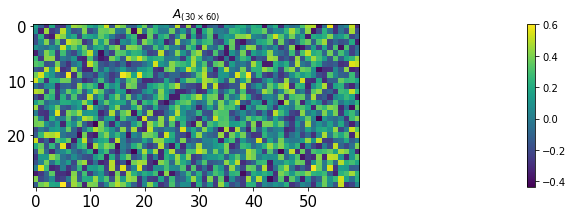

In [ ]:
plt.imshow(A)
plt.rcParams["figure.figsize"] = (60,3)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(np.arange(0,N,10))
plt.yticks(np.arange(0,n,10))
plt.title(r'$A_{(30 \times 60)}$')
cbar = plt.colorbar()
tick_font_size = 10
cbar.ax.tick_params(labelsize=tick_font_size)
plt.savefig("A1.png")
files.download("A1.png")
plt.show()

In [ ]:
# Generating random V (size N x m)

# np.random.seed(1)
V = np.zeros((N,m))
for i in range(m):
    V[:,i] = np.random.rand(N)
    loc = np.argmax(V[:,i])
    V[:,i] = 0
    V[loc,i] = 1

# Measurement vector Y

error_bound = 0.01
num_measures = 10
# Y = np.zeros((n, num_measures))
# for i in range(num_measures):
  # Y[:,i] = (A @ V @ x_original + error_bound * np.random.rand(n,1)).flatten();

Y = A @ V @ x_original + error_bound * np.random.rand(n,1)

# Example Used in MATLAB simulations

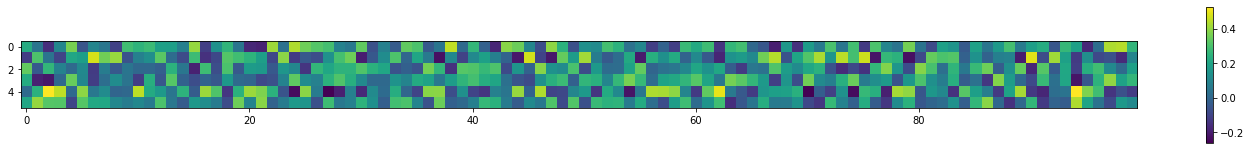

In [ ]:
mat_fname_sparsity = '/content/drive/MyDrive/SLR/Sparsity_A100x6.mat'
mat_contents_SLR = sio.loadmat(mat_fname_sparsity)
A = mat_contents_SLR['A']
Y = mat_contents_SLR['Y']
x_original = mat_contents_SLR['x_original']

mat_fname_LossComp = '/content/drive/MyDrive/SLR/Loss_comp.mat'
mat_contents_LossComp = sio.loadmat(mat_fname_LossComp)
LossComp = mat_contents_LossComp['L_plot']

plt.imshow(A)
plt.rcParams["figure.figsize"] = (25,2.5)
plt.colorbar()
plt.show()

# Defining Free Energy function and its derivative

In [ ]:
def free_energy(z,Y,A,m,La,N,T):
    x = np.zeros((m))
    Q = np.zeros((N,m))
    x[0:m] = z[0:m]
    i , k = m , 0
    while i < len(z):
      Q[:,k] = z[i:i+N]
      i += N
      k += 1

    Qb = Q
    x = x.reshape(-1,1)
    F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))
    return F.flatten()

In [ ]:
def free_energy_grad(z,Y,A,m,La,N,T):
    x = np.zeros((m))
    Q = np.zeros((N,m))
    x[0:m] = z[0:m]
    i , k = m , 0
    while i < len(z):
      Q[:,k] = z[i:i+N]
      i += N
      k += 1

    Qb = Q
    x = x.reshape(-1,1)
    dFdQ = T*np.log(Q/(1-Q)) - 2*A.T@Y@x.T + 2*(A.T @ A) @ Q @ (x @ x.T) + (La @ (x*x).T)*(1 - 2*Q)
    dFdx = -2*(Y - A @ Q @ x).T@ A @ Q + 2*x.T @ np.diag((La.T @ (Q * (1-Q)))[0])
    grad = numpy.concatenate((dFdx.flatten(),np.matrix.flatten(dFdQ, order = 'F')))
    return grad

## MEP_based SLR functional form

In [ ]:
def MEP_SLR(A,Y,m,eps,Tmax):

    Loss = []
    T_iters = []
    Y = Y.reshape(-1,1)

    # Variables

    N = A.shape[1]
    Q = (1/N) * np.ones((N,m))
    La = np.zeros((N,1))

    for i in range(N):
      La[i] = A[:,i].T @ A[:,i]

    x = np.linalg.pinv((A @ Q).T @ A @ Q + np.diag((La.T @ (Q * (1-Q)))[0])) @ (A @ Q).T @ Y

    # Linear constraints and bounds

    beq = np.ones((m))
    Aeq = np.zeros((m,m+N*m))
    for i in range(m):
      Aeq[i,m+N*i:m+N*(i+1)] = 1

    lb = np.zeros((m+N*m))
    lb[0:m] = -1e5*np.ones((m))

    ub = np.ones((m+N*m))
    ub[0:m] = 1e5*np.ones((m))

    # Bounds
    bounds = Bounds(lb, ub)
    # Linear constraint
    linear_constraint = LinearConstraint(Aeq, beq, beq)
    
    # Annealing parameters

    T = Tmax
    alpha = 0.9

    # Annealling

    while np.amin(np.amax(Q,0)) < 1 - eps:
        print("T = ", str(T))
        z0 = np.zeros((m+N*m))
        z0[0:m] = x.flatten()
        i , k = m , 0
        while i < len(z0):
            z0[i:i+N] = Q[:,k]
            i += N
            k += 1

        res = minimize(free_energy, z0, method='SLSQP', jac = free_energy_grad,
                    constraints = linear_constraint, args=(Y,A,m,La,N,T),
                    options={'verbose': 1}, bounds=bounds)
        z = res.x
        x[0:m]  = z[0:m].reshape(-1,1)
        Q = np.ones((N,m))
        i , k = m , 0
        while i < len(z):
            Q[:,k] = z[i:i+N]
            i += N
            k += 1

        print('Maximum p in each column: '+ str(np.amax(Q,0)))
        T = T* alpha
        err = np.linalg.norm(Y - A @ Q @ x)
        Loss.append(err.item())
        T_iters.append(T)

    return x , Q , Loss , T_iters

In [ ]:
x_test , Q_test , Loss_test , T_iters_test = MEP_SLR(A,Y,m = 3,eps = 0.01, Tmax = 10)

In [ ]:
xs = []
Losses = []
Qs = []
for i in range(num_measures):
  print('Results for ' +str(i+1) + 'th error realization')
  x_test , Q_test , Loss_test , T_iters_test = MEP_SLR(A, Y[:,i], m = 1, eps = 0.01, Tmax = 20)
  Qs.append(Q_test)
  Losses.append(Loss_test)
  xs.append(x_test)

Results for 1th error realization
T =  20


<ipython-input-18-ae03b9924fc6>:53: OptimizeWarning: Unknown solver options: verbose
  res = minimize(free_energy, z0, method='SLSQP', jac = free_energy_grad,
<ipython-input-16-225926689667>:13: RuntimeWarning: divide by zero encountered in log
  F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))
<ipython-input-16-225926689667>:13: RuntimeWarning: invalid value encountered in multiply
  F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))


Maximum p in each column: [0.03729233]
T =  18.0
Maximum p in each column: [0.04304511]
T =  16.2
Maximum p in each column: [0.05068475]
T =  14.58
Maximum p in each column: [0.06517415]
T =  13.122
Maximum p in each column: [0.09593562]
T =  11.809800000000001
Maximum p in each column: [0.44140931]
T =  10.628820000000001
Maximum p in each column: [0.52621265]
T =  9.565938000000001
Maximum p in each column: [0.55105185]
T =  8.6093442
Maximum p in each column: [0.5691495]
T =  7.748409780000001
Maximum p in each column: [0.58275225]
T =  6.973568802000001
Maximum p in each column: [0.59628035]
T =  6.276211921800001
Maximum p in each column: [0.61094677]
T =  5.64859072962
Maximum p in each column: [0.62822601]
T =  5.083731656658
Maximum p in each column: [0.64818211]
T =  4.5753584909922
Maximum p in each column: [0.67668199]
T =  4.11782264189298
Maximum p in each column: [0.7005993]
T =  3.706040377703682
Maximum p in each column: [0.73085076]
T =  3.3354363399333136
Maximum p in

In [ ]:
xs_m1 = xs
Qs_m1 = Qs
Losses_m1 = Losses

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

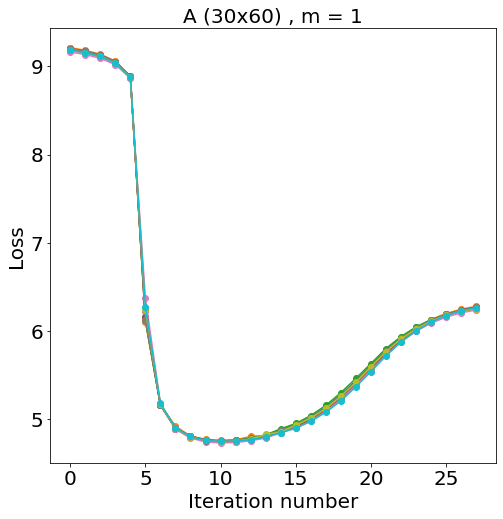

In [ ]:
for i in range(num_measures):
  Loss , Q , x = Losses_m1[i], Qs_m1[i], xs_m1[i]
  n_iters = np.arange(len(Loss))
  plt.plot(n_iters, Loss, '-o', label = "Error"+str(i+1))

plt.xlabel("Iteration number", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.title("A (30x60) , m = 1", fontsize = 20)
plt.savefig("Error_m1_30x60.png")
files.download("Error_m1_30x60.png")
# plt.legend()
plt.show()
plt.rcParams['figure.figsize'] = [8,8]
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

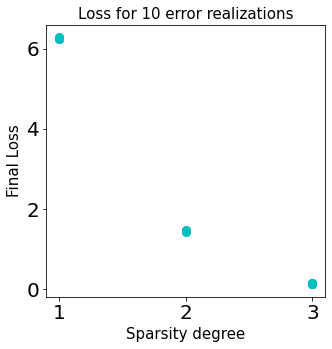

In [ ]:
Loss_error_m3 = np.zeros(num_measures)
Loss_error_m2 = np.zeros(num_measures)
Loss_error_m1 = np.zeros(num_measures)
for i in range(num_measures):
  Loss_error_m3[i] = Losses_m3[i][-1]

for i in range(num_measures):
  Loss_error_m2[i] = Losses_m2[i][-1]

for i in range(num_measures):
  Loss_error_m1[i] = Losses_m1[i][-1]
  
plt.plot(3*np.ones(num_measures), Loss_error_m3, 'co', markersize = 8)
plt.plot(2*np.ones(num_measures), Loss_error_m2, 'co',  markersize = 8)
plt.plot(1*np.ones(num_measures), Loss_error_m1, 'co',  markersize = 8)
plt.xlabel("Sparsity degree", fontsize = 15)
plt.ylabel("Final Loss", fontsize = 15)
plt.xticks(np.arange(3)+1)
plt.title("Loss for 10 error realizations", fontsize = 15)
plt.savefig("Error_rlz_m3.png")
files.download("Error_rlz_m3.png")
plt.show()
plt.rcParams['figure.figsize'] = [5,5]

## Defining Linear constraints and bounds

In [ ]:
beq = np.ones((m))
Aeq = np.zeros((m,m+N*m))
for i in range(m):
  Aeq[i,m+N*i:m+N*(i+1)] = 1

lb = np.zeros((m+N*m))
lb[0:m] = -1e5*np.ones((m))

ub = np.ones((m+N*m))
ub[0:m] = 1e5*np.ones((m))

## Algorithm

In [ ]:
# Input

m = 3
Loss1 = []
T_iters = []

# Variables

N = A.shape[1]
Q = (1/N) * np.ones((N,m))
La = np.zeros((N,1))

for i in range(N):
  La[i] = A[:,i].T @ A[:,i]

x = np.linalg.pinv((A @ Q).T @ A @ Q + np.diag((La.T @ (Q * (1-Q)))[0])) @ (A @ Q).T @ Y

In [ ]:
# Annealing parameters

T = 10
alpha = 0.9
eps = 0.01

In [ ]:
# Bounds
bounds = Bounds(lb, ub)
# Linear constraint
linear_constraint = LinearConstraint(Aeq, beq, beq)

In [ ]:
# Algorithm

while np.amin(np.amax(Q,0)) < 1 - eps:
    print("T = ", str(T))
    z0 = np.zeros((m+N*m))
    z0[0:m] = x.flatten()
    i , k = m , 0
    while i < len(z0):
        z0[i:i+N] = Q[:,k]
        i += N
        k += 1

    res = minimize(free_energy, z0, method='SLSQP', jac = free_energy_grad,
                constraints = linear_constraint, args=(Y,A,m,La,N,T),
                options={'verbose': 1}, bounds=bounds)
    z = res.x
    x[0:m]  = z[0:m].reshape(-1,1)
    Q = np.ones((N,m))
    i , k = m , 0
    while i < len(z):
        Q[:,k] = z[i:i+N]
        i += N
        k += 1

    print('Maximum p in each column: '+ str(np.amax(Q,0)))
    T = T* alpha
    err = np.linalg.norm(Y - A @ Q @ x)
    Loss1.append(err.item())
    T_iters.append(T)

T =  10


<ipython-input-32-be549f6d3893>:13: OptimizeWarning: Unknown solver options: verbose
  res = minimize(free_energy, z0, method='SLSQP', jac = free_energy_grad,
<ipython-input-25-225926689667>:13: RuntimeWarning: divide by zero encountered in log
  F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))
<ipython-input-25-225926689667>:13: RuntimeWarning: invalid value encountered in multiply
  F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))


Maximum p in each column: [0.05469962 0.05470119 0.05470459]
T =  9.0
Maximum p in each column: [0.06861956 0.06861626 0.06861156]
T =  8.1
Maximum p in each column: [0.09094283 0.09098277 0.09108475]
T =  7.29
Maximum p in each column: [0.12711495 0.1270549  0.12675263]
T =  6.561
Maximum p in each column: [0.97346136 0.02062734 0.02111107]
T =  5.9049000000000005
Maximum p in each column: [0.9879554  0.02242661 0.02142287]
T =  5.3144100000000005
Maximum p in each column: [0.99340537 0.02255023 0.0225469 ]
T =  4.7829690000000005
Maximum p in each column: [0.99644278 0.02348241 0.02347848]
T =  4.3046721
Maximum p in each column: [0.99815978 0.02456995 0.02457198]
T =  3.8742048900000006
Maximum p in each column: [0.9991122  0.02594244 0.02587392]
T =  3.4867844010000004
Maximum p in each column: [0.99957581 0.02759597 0.0275298 ]
T =  3.1381059609000004
Maximum p in each column: [0.99983215 0.02959256 0.02948311]
T =  2.82429536481
Maximum p in each column: [0.99992917 0.03219916 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

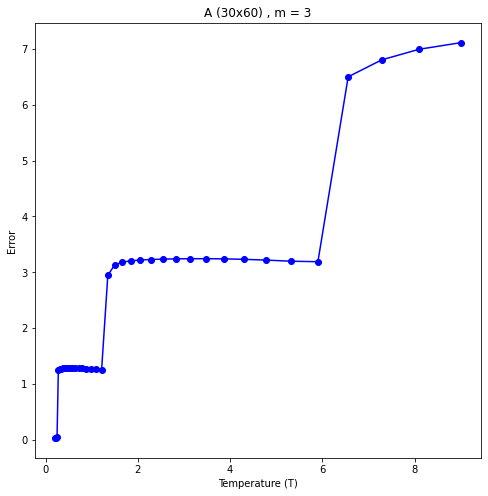

In [ ]:
plt.plot(T_iters, Loss1, 'b-o', label = "Error")
plt.xlabel("Temperature (T)")
plt.ylabel("Error")
plt.title("A (30x60) , m = 3")
plt.savefig("Error_T_30x60.pdf")
files.download("Error_T_30x60.pdf")
plt.show()
plt.rcParams['figure.figsize'] = [8,8]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

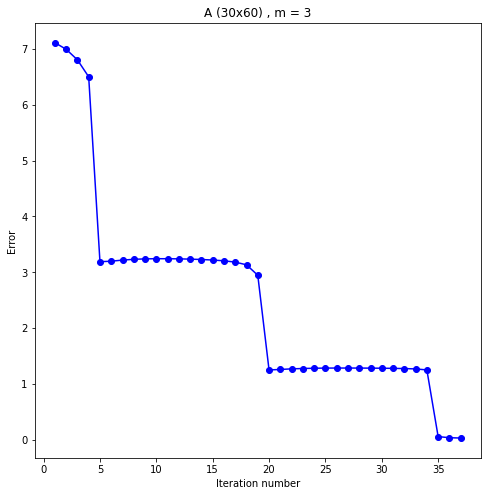

In [ ]:
iters = np.arange(len(T_iters))+1
plt.plot(iters, Loss1, 'b-o', label = "Error")
plt.xlabel("Iteration number")
plt.ylabel("Error")
plt.title("A (30x60) , m = 3")
plt.savefig("Error_iter_30x60.pdf")
files.download("Error_iter_30x60.pdf")
plt.show()
plt.rcParams['figure.figsize'] = [8,8]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

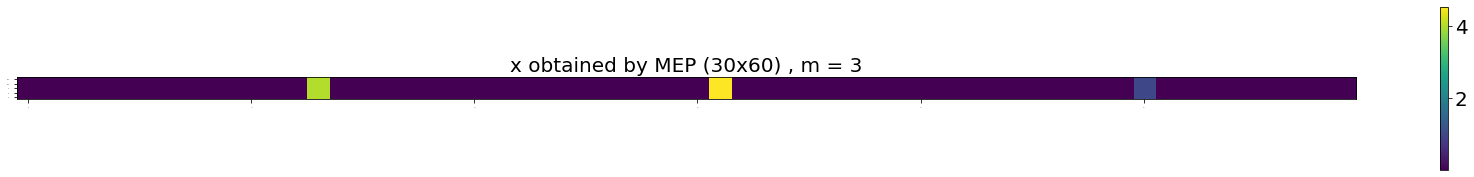

In [ ]:
plt.imshow((Qs_m3[-1]@xs_m3[-1]).T)
plt.title("x obtained by MEP (30x60) , m = 3", fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=1)
plt.savefig("sparse_x.png")
files.download("sparse_x.png")
plt.rcParams["figure.figsize"] = (30,3)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

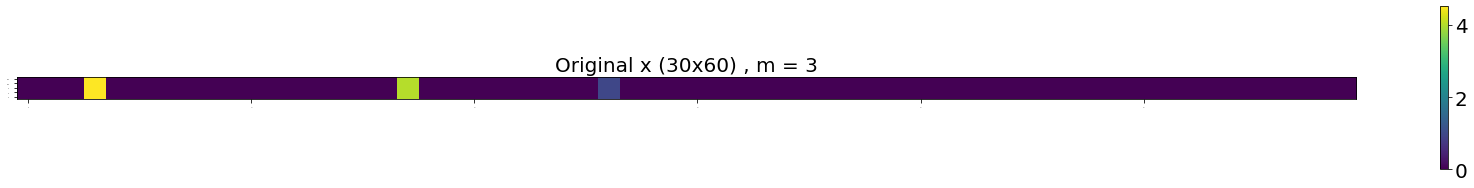

In [ ]:
plt.imshow((V@x_original).T)
plt.title("Original x (30x60) , m = 3", fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=1)
plt.savefig("sparse_x.png")
files.download("sparse_x.png")
plt.rcParams["figure.figsize"] = (30,3)
plt.colorbar()
plt.show()

In [ ]:
x_test , Q_test , Loss_test , T_iters_test = MEP_SLR(A,Y,m = 1,eps = 0.01, Tmax = 10)

T =  10


<ipython-input-18-ae03b9924fc6>:53: OptimizeWarning: Unknown solver options: verbose
  res = minimize(free_energy, z0, method='SLSQP', jac = free_energy_grad,
<ipython-input-16-225926689667>:13: RuntimeWarning: divide by zero encountered in log
  F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))
<ipython-input-16-225926689667>:13: RuntimeWarning: invalid value encountered in multiply
  F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))


Maximum p in each column: [0.0518524]
T =  9.0
Maximum p in each column: [0.0635508]
T =  8.1
Maximum p in each column: [0.08294391]
T =  7.29
Maximum p in each column: [0.12738551]
T =  6.561
Maximum p in each column: [0.6796843]
T =  5.9049000000000005
Maximum p in each column: [0.71375459]
T =  5.3144100000000005
Maximum p in each column: [0.73435404]
T =  4.7829690000000005
Maximum p in each column: [0.7509553]
T =  4.3046721
Maximum p in each column: [0.7666155]
T =  3.8742048900000006
Maximum p in each column: [0.78161456]
T =  3.4867844010000004
Maximum p in each column: [0.79624158]
T =  3.1381059609000004
Maximum p in each column: [0.81381348]
T =  2.82429536481
Maximum p in each column: [0.82666888]
T =  2.541865828329
Maximum p in each column: [0.83980916]
T =  2.2876792454961
Maximum p in each column: [0.85292885]
T =  2.05891132094649
Maximum p in each column: [0.86582993]
T =  1.853020188851841
Maximum p in each column: [0.87860991]
T =  1.6677181699666568
Maximum p in ea

In [ ]:
Final_Error_m1 = Loss_test[-1]
print(Final_Error_m1)

5.339663783601694


In [ ]:
Loss_MEP = [Final_Error_m1, Final_Error_m2, Final_Error_m3]

## Comparison with other algorithms

In [ ]:
LossComp_m4 = LossComp[:,0:-1]
LossComp_m4.shape

(5, 4)

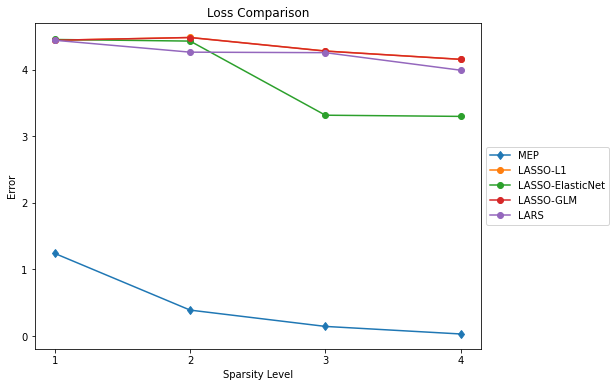

In [ ]:
# Loss_MEP = [Loss1[-1], Loss2[-1], Loss3[-1], Loss4[-1]] 
Loss_MEP = np.array([1.239466180864918110e+00, 3.884360534404434628e-01, 1.434263373647165218e-01, 2.986057316641685389e-02])
num = np.arange(4)
plt.plot(num+1, Loss_MEP, '-d', label = 'MEP')
plt.plot(num+1, LossComp_m4[1,:], '-o', label = "LASSO-L1")
plt.plot(num+1, LossComp_m4[2,:], '-o', label = "LASSO-ElasticNet")
plt.plot(num+1, LossComp_m4[3,:], '-o', label = "LASSO-GLM")
plt.plot(num+1, LossComp_m4[4,:], '-o', label = "LARS")
plt.xticks(num+1)
plt.xlabel("Sparsity Level")
plt.ylabel("Error")
plt.title("Loss Comparison")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.figsize"] = (8,6)

In [ ]:
from sklearn.linear_model import lasso_path, enet_path, lars_path

# LASSO
alphas_lasso, coefs_lasso, _ = lasso_path(A, Y.flatten(), eps = 10e-3)

# ElasticNet
alphas_enet, coefs_enet, _ = enet_path(A, Y.flatten(), eps = 10e-3, l1_ratio=0.95)

# LARS
alphas_lars, _ , coefs_lars = lars_path(A, Y.flatten())

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=3.438e-04, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=3.016e-04, with an active set of 31 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.947e-04, with an active set of 31 regressors, and the smallest cholesky pivot element bein

In [ ]:
n_alphas = alphas_lasso.shape[0]
Loss_lasso = np.zeros(n_alphas)
Loss_enet = np.zeros(n_alphas)
for i in range (n_alphas):
  Loss_lasso[i] = np.linalg.norm(Y.flatten() - A@coefs_lasso[:,i])
  Loss_enet[i] = np.linalg.norm(Y.flatten() - A@coefs_enet[:,i])

n_alphas_lars = alphas_lars.shape[0]
Loss_lars = np.zeros(n_alphas_lars)
for i in range (n_alphas_lars):
  Loss_lars[i] = np.linalg.norm(Y.flatten() - A@coefs_lars[:,i])

In [ ]:
alphas_lars.shape

(41,)

### LASSO_L1

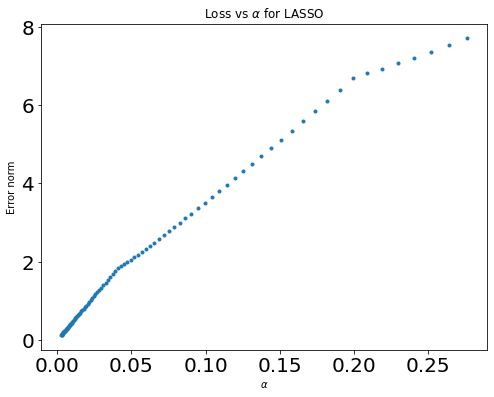

In [ ]:
plt.plot(alphas_lasso,Loss_lasso, '.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"Error norm")
plt.title(r"Loss vs $\alpha$ for LASSO")
plt.rcParams["figure.figsize"] = (8,6)

In [ ]:
columns = (coefs_lasso != 0).sum(0)
print(columns)
max_sparsity = 3
minLoss_lasso = np.zeros((max_sparsity)+1)
for i in range(max_sparsity+1):
  if len(columns[columns == i]) == 0:
      minLoss_lasso[i] = 0
  else:
      minLoss_lasso[i] = np.min(Loss_lasso[columns == i])

print(minLoss_lasso)

[0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[7.69844631 6.80477142 1.84384885 0.38157148]


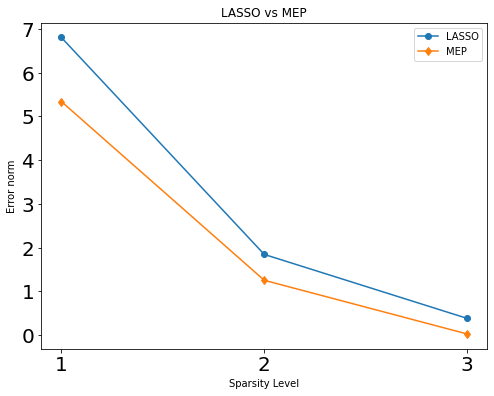

In [ ]:
plt.plot(np.arange(max_sparsity)+1,minLoss_lasso[1:], '-o', label = 'LASSO')
plt.plot(np.arange((max_sparsity))+1, Loss_MEP, '-d', label = 'MEP')
plt.xlabel(r"Sparsity Level")
plt.ylabel(r"Error norm")
plt.title(r"LASSO vs MEP")
plt.xticks(np.arange(max_sparsity)+1)
plt.legend(loc = 'upper right')
plt.rcParams["figure.figsize"] = (8,6)

### ElasticNet

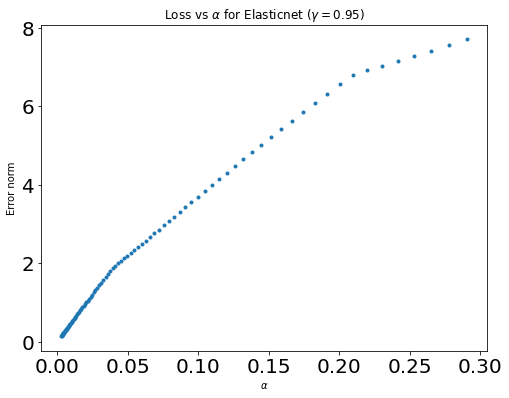

In [ ]:
plt.plot(alphas_enet,Loss_enet, '.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"Error norm")
plt.title(r"Loss vs $\alpha$ for Elasticnet ($\gamma = 0.95$)")
plt.rcParams["figure.figsize"] = (8,6)

In [ ]:
columns = (coefs_enet != 0).sum(0)
print(columns)
max_sparsity = 3
minLoss_enet = np.zeros((max_sparsity)+1)
for i in range(max_sparsity+1):
  if len(columns[columns == i]) == 0:
      minLoss_enet[i] = 0
  else:
      minLoss_enet[i] = np.min(Loss_lasso[columns == i])

print(minLoss_lasso)

[1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[7.69844631 6.80477142 1.84384885 0.38157148]


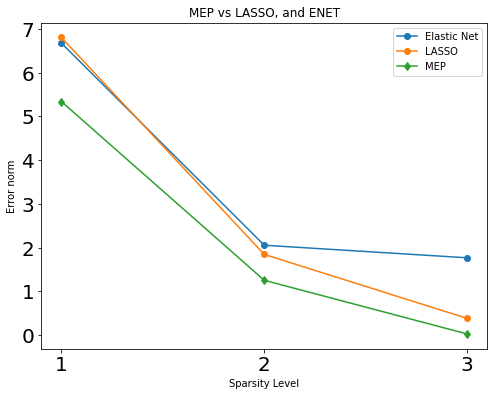

In [ ]:
plt.plot(np.arange(max_sparsity)+1,minLoss_enet[1:], '-o', label = 'Elastic Net')
plt.plot(np.arange(max_sparsity)+1,minLoss_lasso[1:], '-o', label = 'LASSO')
plt.plot(np.arange((max_sparsity))+1, Loss_MEP, '-d', label = 'MEP')
plt.xlabel(r"Sparsity Level")
plt.ylabel(r"Error norm")
plt.title(r"MEP vs LASSO, and ENET")
plt.xticks(np.arange(max_sparsity)+1)
plt.legend(loc = 'upper right')
plt.rcParams["figure.figsize"] = (8,6)

### LARS

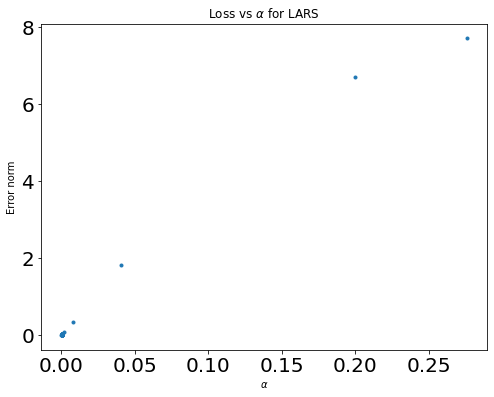

In [ ]:
plt.plot(alphas_lars,Loss_lars, '.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"Error norm")
plt.title(r"Loss vs $\alpha$ for LARS")
plt.rcParams["figure.figsize"] = (8,6)

In [ ]:
columns = (coefs_lars != 0).sum(0)
print(columns)
max_sparsity = 3
minLoss_lars = np.zeros((max_sparsity)+1)
for i in range(max_sparsity+1):
  if len(columns[columns == i]) == 0:
      minLoss_lars[i] = 0
  else:
      minLoss_lars[i] = np.min(Loss_lars[columns == i])

print(columns)
print(minLoss_lars)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 23 23 24 24 25 25 26 26 26 26 27 27 28 29 30 31 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 23 23 24 24 25 25 26 26 26 26 27 27 28 29 30 31 31]
[7.69844631 6.69888546 1.83572437 0.35426385]


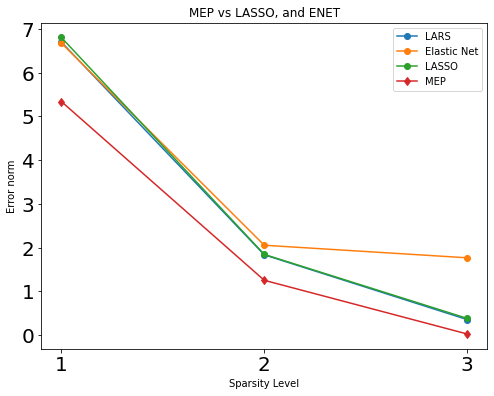

In [ ]:
plt.plot(np.arange(max_sparsity)+1,minLoss_lars[1:], '-o', label = 'LARS')
plt.plot(np.arange(max_sparsity)+1,minLoss_enet[1:], '-o', label = 'Elastic Net')
plt.plot(np.arange(max_sparsity)+1,minLoss_lasso[1:], '-o', label = 'LASSO')
plt.plot(np.arange((max_sparsity))+1, Loss_MEP, '-d', label = 'MEP')
plt.xlabel(r"Sparsity Level")
plt.ylabel(r"Error norm")
plt.title(r"MEP vs LASSO, and ENET")
plt.xticks(np.arange(max_sparsity)+1)
plt.legend(loc = 'upper right')
plt.rcParams["figure.figsize"] = (8,6)

## Adaptive LASSO

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.utils import resample

def adaptive_lasso(X, y, alpha, max_iter=1000, tol=1e-3):
    """
    Adaptive Lasso algorithm for sparse linear regression
    
    Parameters
    ----------
    X : numpy array, shape (n_samples, n_features)
        The design matrix
    y : numpy array, shape (n_samples,)
        The target values
    alpha : float
        The regularization strength
    max_iter : int, optional (default=1000)
        Maximum number of iterations for the coordinate descent solver
    tol : float, optional (default=1e-4)
        Tolerance for stopping criterion of the coordinate descent solver
    
    Returns
    -------
    w : numpy array, shape (n_features,)
        The estimated coefficients
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    weights = np.ones(n_features)

    for i in range(max_iter):
        w_prev = w.copy()
        for j in range(n_features):
            X_j = X[:, j]
            X_not_j = np.delete(X, j, axis=1)
            w_not_j = np.delete(w, j)
            y_pred = X_not_j.dot(w_not_j)
            r = y - y_pred
            # calculate the L1 penalty weight
            z = weights[j] * alpha
            # update the j-th weight using the Lasso regression
            model = Lasso(alpha=z, max_iter=1e5, tol=tol)
            model.fit(X_j.reshape(-1, 1), r)
            w[j] = model.coef_[0]
            # update the j-th weight using the Adaptive Lasso formula
            weights[j] = 1.0 / np.abs(w[j] + 1e-10)
        # check for convergence
        if np.linalg.norm(w - w_prev) < tol:
            break

    return w


In [ ]:
n , N = A.shape
alphas_alasso = np.concatenate((np.linspace(0.2, 0.01, 50), np.linspace(0.01, 0.0005, 150)))
# alphas_alasso = np.linspace(0.3, 0.01, 100)
coefs_alasso = np.zeros((N,len(alphas_alasso)))
Loss_alasso = np.zeros(len(alphas_alasso))
i = 0
for alpha in alphas_alasso:
    coefs_alasso[:,i] = adaptive_lasso(A, Y.flatten(), alpha)
    Loss_alasso[i] = np.linalg.norm(Y.flatten() - A @ coefs_alasso[:,i])
    i += 1
    if np.mod(i,20) == 0:
      print('i = ' + str(i))

i = 20
i = 40
i = 60
i = 80
i = 100
i = 120
i = 140
i = 160
i = 180
i = 200


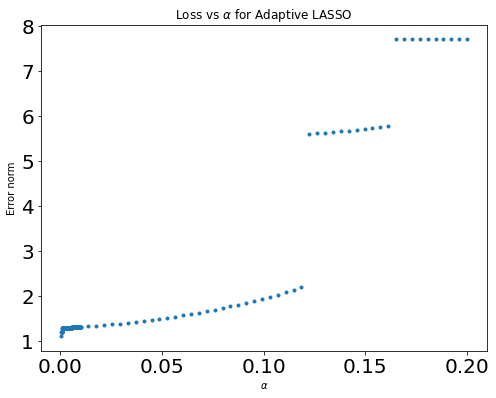

In [ ]:
plt.plot(alphas_alasso,Loss_alasso, '.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"Error norm")
plt.title(r"Loss vs $\alpha$ for Adaptive LASSO")
plt.rcParams["figure.figsize"] = (8,6)

In [ ]:
columns = (coefs_alasso != 0).sum(0)
print(columns)
max_sparsity = 3
minLoss_alasso = np.zeros((max_sparsity)+1)
for i in range(max_sparsity+1):
  if len(columns[columns == i]) == 0:
      minLoss_lars[i] = 0
  else:
      minLoss_alasso[i] = np.min(Loss_alasso[columns == i])

print(minLoss_alasso)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4]
[7.69844631 5.60544804 1.29080924 1.19665836]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

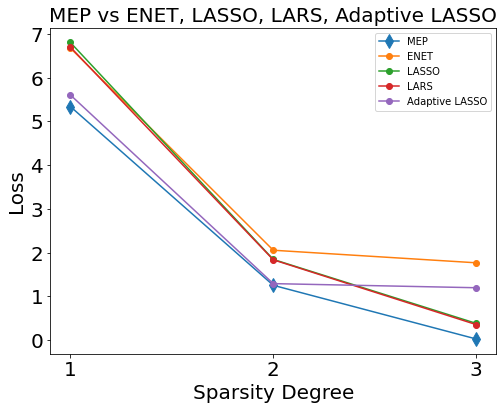

In [ ]:
plt.plot(np.arange(max_sparsity)+1,Loss_MEP, '-d', label = 'MEP', markersize = 10)
plt.plot(np.arange(max_sparsity)+1,minLoss_enet[1:], '-o', label = 'ENET')
plt.plot(np.arange(max_sparsity)+1,minLoss_lasso[1:], '-o', label = 'LASSO')
plt.plot(np.arange(max_sparsity)+1,minLoss_lars[1:], '-o', label = 'LARS')
plt.plot(np.arange(max_sparsity)+1,minLoss_alasso[1:], '-o', label = 'Adaptive LASSO')
plt.xlabel(r"Sparsity Degree", fontsize = 20)
plt.ylabel(r"Loss", fontsize = 20)
plt.title(r"MEP vs ENET, LASSO, LARS, Adaptive LASSO", fontsize = 20)
plt.xticks(np.arange(len(minLoss_enet)-1)+1)
plt.legend()
plt.savefig("Comparison.png")
files.download("Comparison.png")
plt.rcParams["figure.figsize"] = (8,6)

#LASSO Benchmarking Examples

In [ ]:
!git clone https://github.com/mathurinm/libsvmdata

Cloning into 'libsvmdata'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 255 (delta 78), reused 74 (delta 74), pack-reused 153
Receiving objects: 100% (255/255), 47.22 KiB | 386.00 KiB/s, done.
Resolving deltas: 100% (106/106), done.


In [ ]:
!pip install git+https://github.com/mathurinm/libsvmdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mathurinm/libsvmdata to /tmp/pip-req-build-o5wwwnl8
  Running command git clone --filter=blob:none --quiet https://github.com/mathurinm/libsvmdata /tmp/pip-req-build-o5wwwnl8
  Resolved https://github.com/mathurinm/libsvmdata to commit db34488c2ea6d654dc1c86d2277c722f39b1b7db
  Preparing metadata (setup.py) ... done
  Created wheel for libsvmdata: filename=libsvmdata-0.5.dev0-py3-none-any.whl size=7070 sha256=2a21ea86274376953593b9c4f8b1000da21887f6085bd755efc276e06aeb4619
  Stored in directory: /tmp/pip-ephem-wheel-cache-2zd8age1/wheels/35/93/9d/698a5521ffa138c52dfdf10cc58b4ff5124ddbf42e28b58a68
Successfully built libsvmdata


In [ ]:
import libsvmdata

In [ ]:
from libsvmdata import fetch_libsvm
X_dbs, y_dbs = fetch_libsvm("diabetes")

In [ ]:
from sklearn.linear_model import lasso_path, enet_path, lars_path

# LASSO
alphas_lasso, coefs_lasso, _ = lasso_path(X_lkm, y_lkm, eps = 10e-3)

n_alphas = alphas_lasso.shape[0]
Loss_lasso = np.zeros(n_alphas)
for i in range (n_alphas):
  Loss_lasso[i] = np.linalg.norm(y_lkm - X_lkm @ coefs_lasso[:,i])

columns = (coefs_lasso != 0).sum(0)
print(columns)

[ 0  3  3  3  4  4  4  5  8  8  8 10 10 10 12 13 13 13 14 14 15 16 17 17
 16 17 19 18 18 18 19 20 19 19 20 20 21 23 24 24 23 22 23 26 25 25 26 25
 25 25 25 27 28 28 26 25 26 26 27 30 32 31 30 29 28 29 29 30 31 31 31 31
 33 32 32 32 33 34 35 35 35 36 36 36 36 37 35 34 34 32 32 33 33 36 37 37
 37 38 39 39]


In [ ]:
y_dbs

array([-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,
       -1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
       -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
        1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1

In [ ]:
# alphas_t = np.linspace(min(alphas_lasso)//2.5, min(alphas_lasso),100)

In [ ]:
# from sklearn.linear_model import lasso_path, enet_path, lars_path

## LASSO
# alphas_lasso, coefs_lasso, _ = lasso_path(X_brc, y_brc, eps = 10e-3, alphas = alphas_t/4900)

In [ ]:
n_alphas = alphas_lasso.shape[0]
Loss_lasso = np.zeros(n_alphas)
for i in range (n_alphas):
  Loss_lasso[i] = np.linalg.norm(y_lkm - X_lkm @ coefs_lasso[:,i])

In [ ]:
columns = (coefs_lasso != 0).sum(0)
print(columns)

[ 0  3  3  3  4  4  4  5  8  8  8 10 10 10 12 13 13 13 14 14 15 16 17 17
 16 17 19 18 18 18 19 20 19 19 20 20 21 23 24 24 23 22 23 26 25 25 26 25
 25 25 25 27 28 28 26 25 26 26 27 30 32 31 30 29 28 29 29 30 31 31 31 31
 33 32 32 32 33 34 35 35 35 36 36 36 36 37 35 34 34 32 32 33 33 36 37 37
 37 38 39 39]


In [ ]:
N , n = X_lkm.shape

In [ ]:
max_sparsity = 30
columns = (coefs_lasso != 0).sum(0)
minLoss_lasso = np.zeros((max_sparsity)+1)
for i in range(max_sparsity+1):
  if len(columns[columns == i]) == 0:
      minLoss_lasso[i] = 0
  else:
      minLoss_lasso[i] = np.min(Loss_lasso[columns == i])

print(columns)
print(minLoss_lasso)

[ 0  3  3  3  4  4  4  5  8  8  8 10 10 10 12 13 13 13 14 14 15 16 17 17
 16 17 19 18 18 18 19 20 19 19 20 20 21 23 24 24 23 22 23 26 25 25 26 25
 25 25 25 27 28 28 26 25 26 26 27 30 32 31 30 29 28 29 29 30 31 31 31 31
 33 32 32 32 33 34 35 35 35 36 36 36 36 37 35 34 34 32 32 33 33 36 37 37
 37 38 39 39]
[6.164414   0.         0.         5.63513755 5.16526141 5.02463483
 0.         0.         4.58203662 0.         4.15128506 0.
 4.00949599 3.62627844 3.39572088 3.28503496 2.88108788 2.79128527
 2.46587434 2.13038215 1.98258253 1.91335162 1.59831038 1.54083669
 1.72190069 0.93730924 0.87763133 0.84992043 0.6614218  0.61036227
 0.58564482]


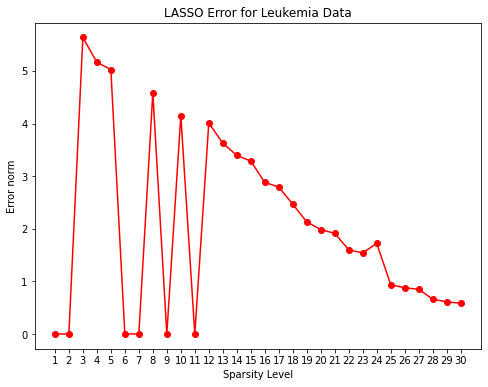

In [ ]:
plt.plot(np.arange((max_sparsity))+1,minLoss_lasso[1:], 'r-o')
plt.xlabel(r"Sparsity Level")
plt.ylabel(r"Error norm")
plt.title(r"LASSO Error for Leukemia Data")
plt.xticks(np.arange((max_sparsity))+1)
plt.rcParams["figure.figsize"] = (8,6)

In [ ]:
np.amax(X_lkm,1)

array([7.55998, 7.95881, 6.19189, 4.322  , 8.16221, 4.2488 , 7.74971,
       6.26657, 6.76121, 6.37658, 5.76677, 4.43953, 4.98854, 8.09452,
       6.06521, 4.80567, 7.61485, 7.67742, 6.05276, 8.00756, 7.60042,
       7.64478, 7.87535, 4.76996, 6.83153, 5.80195, 5.52368, 7.17145,
       6.68162, 6.96084, 4.88009, 8.29407, 8.18531, 3.84648, 4.45749,
       8.19396, 7.84043, 7.51151])

In [ ]:
y_lkm

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

## Signal Reconstruction Example

### Convex Optimization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sys.path.append(os.path.join('..','UTILS'))

In [ ]:
## Generate signal, DCT of signal

n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)
xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density

In [ ]:
## Randomly sample signal
p = 128 # num. random samples, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]

In [ ]:
## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[perm,:]       # Measure rows of Psi

In [ ]:
## L1-Minimization using SciPy
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y 
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x

In [ ]:
xrecon_CVX = idct(s) # reconstruct full signal

In [ ]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


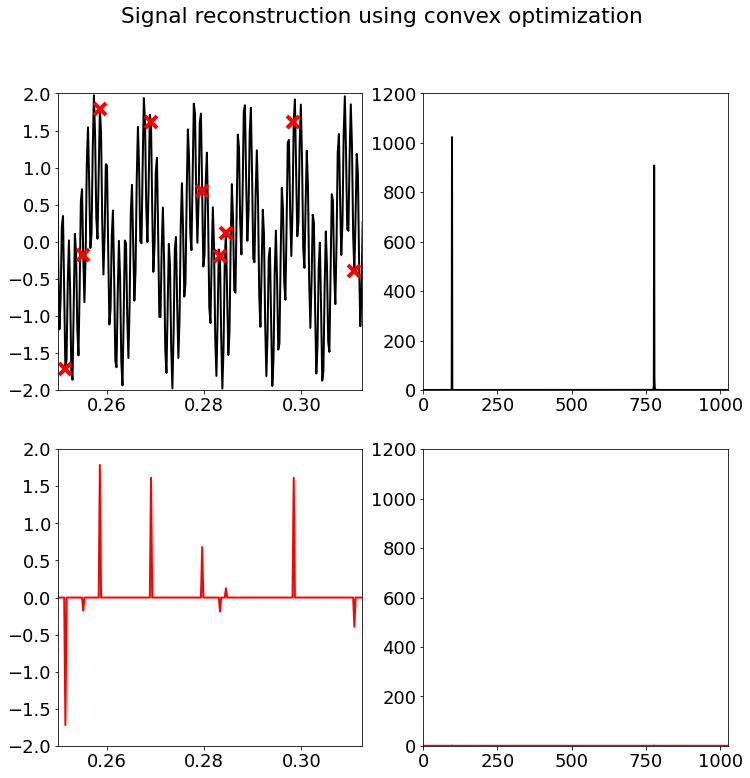

In [ ]:
## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
fig.suptitle('Signal reconstruction using convex optimization')
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon_CVX,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon_CVX,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

### LASSO

In [ ]:
from sklearn.linear_model import lasso_path, enet_path, lars_path

# LASSO
alphas_lasso, coefs_lasso, _ = lasso_path(Theta, y, eps = 10e-3)

In [ ]:
n_alphas = alphas_lasso.shape[0]
Loss_lasso = np.zeros(n_alphas)
for i in range (n_alphas):
  Loss_lasso[i] = np.linalg.norm(y - Theta@coefs_lasso[:,i])

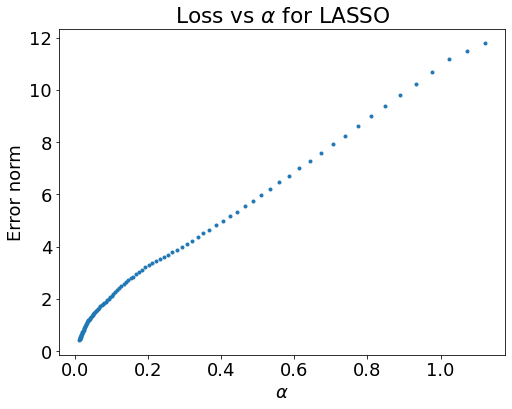

In [ ]:
plt.plot(alphas_lasso,Loss_lasso, '.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"Error norm")
plt.title(r"Loss vs $\alpha$ for LASSO")
plt.rcParams["figure.figsize"] = (4,3)

In [ ]:
columns = (coefs_lasso != 0).sum(0)
print(columns)
sparsity = 2
min_index = np.argmin(Loss_lasso[columns == sparsity])
min_Loss = np.min(Loss_lasso[columns == sparsity])
coefs_lasso_sp = coefs_lasso[:,columns == sparsity]
s_lasso = coefs_lasso_sp[:,min_index]
print(min_Loss)
print(np.linalg.norm(y - Theta @ s_lasso))

[ 0  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  6  7  7  7  7  7  8  9 10 11 13 13 17
 20 22 25 27 32 33 37 40 45 50 55 57 60 61 62 66 69 71 74 74 74 77 79 80
 82 82 82 82]
3.3044333980122214
3.3044333980122214


In [ ]:
xrecon_lasso = idct(s_lasso) # reconstruct full signal

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


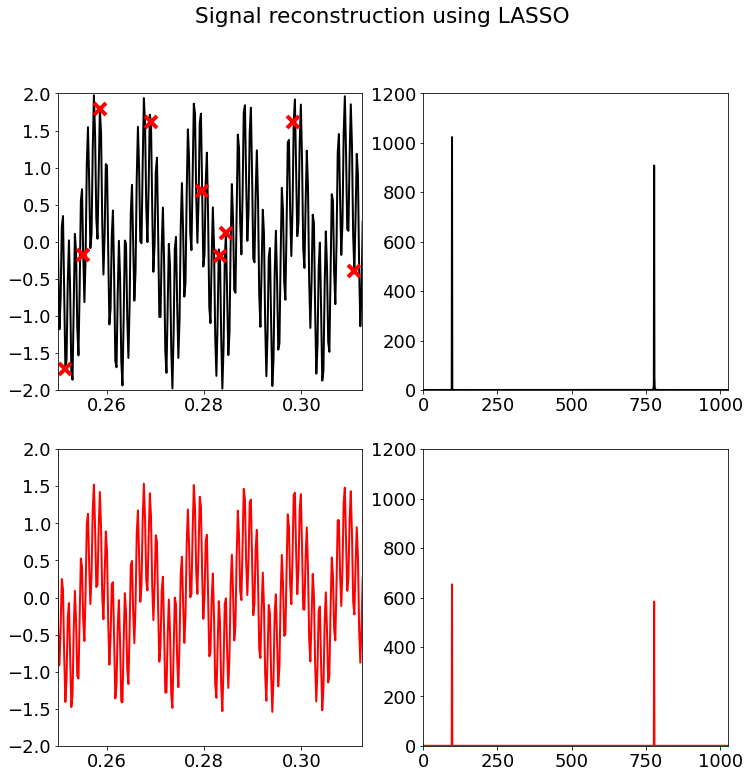

In [ ]:
## Plot
plt.rcParams['figure.figsize'] = [12, 12]
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
fig.suptitle('Signal reconstruction using LASSO')
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon_lasso,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon_lasso,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

### MEP

In [ ]:
x_MEP_SR , Q_MEP_SR , _ , _ = MEP_SLR(Theta,y,m = 2,eps = 0.01, Tmax = 10)

T =  10


<ipython-input-9-ae03b9924fc6>:53: OptimizeWarning: Unknown solver options: verbose
  res = minimize(free_energy, z0, method='SLSQP', jac = free_energy_grad,
<ipython-input-7-225926689667>:13: RuntimeWarning: divide by zero encountered in log
  F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))
<ipython-input-7-225926689667>:13: RuntimeWarning: invalid value encountered in multiply
  F = np.linalg.norm(Y - A @ Q @ x)**2 + x.T @ np.diag((La.T @ (Q * (1-Q)))[0]) @ x + T*np.ones((1,N))@(Qb*np.log(Qb) + (1-Qb)*np.log(1-Qb)) @ np.ones((m,1))


Maximum p in each column: [0.00024504 0.00024504]
T =  9.0


In [ ]:
xrecon_MEP = idct(Q_MEP_SR @ x_MEP_SR) # reconstruct full signal

In [ ]:
## Plot
plt.rcParams['figure.figsize'] = [12, 12]
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
fig.suptitle('Signal reconstruction using MEP')
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon_MEP,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon_MEP,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()